In [1]:
# !pip install datasets
# !pip install transformers[torch]
# !pip install accelerate -U

In [2]:
import torch
from src.utils import *
from src.models.BERT_Model_Phrase_Concatenation import *
from src.models.BERT_Model_Phrase_Extraction import *
from src.models.baseline import Baseline
from datasets import concatenate_datasets
from transformers import DefaultDataCollator, AutoTokenizer, TrainingArguments, Trainer

C:\Users\mpsta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
RANDOM_SEED = 42
set_seeds(RANDOM_SEED)

print(torch.__version__)
print(torch.cuda.is_available())

2.2.2+cu121
True


In [4]:
url = "https://drive.google.com/uc?export=download&id=1wVNU2XvvhqjaGXZM-JLJwOt97gt4g9j2"
dataset_name = "MELD_train_efr.json"

df_manager = DataframeManager(url, dataset_name)

df = df_manager.produce_df()
df

Current work directory: d:\bologna\codes\ediref


,episode,emotions,utterances,triggers,emotions_id
0,utterance_0,"[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0, 0, 0, 1, 0]","[6, 6, 6, 6, 5]"
1,utterance_1,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 1, 0]","[6, 6, 6, 6, 5, 6, 6]"
2,utterance_2,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]","[6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 3]"
3,utterance_3,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 3, 6, 5]"
4,utterance_4,"[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0, 0, 1, 0]","[5, 0, 5, 3]"
...,...,...,...,...,...
3995,utterance_3995,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[6, 2, 6, 6, 5, 1, 6, 1, 5, 6, 6, 1]"
3996,utterance_3996,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[6, 2, 6, 6, 5, 1, 6, 1, 5, 6, 6, 1, 1, 6]"
3997,utterance_3997,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[6, 2, 6, 6, 5, 1, 6, 1, 5, 6, 6, 1, 1, 6, 6]"
3998,utterance_3998,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[6, 2, 6, 6, 5, 1, 6, 1, 5, 6, 6, 1, 1, 6, 6, 5]"


In [5]:
train_df, val_df, test_df = df_manager.split_df(RANDOM_SEED)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(3200, 5)
(400, 5)
(400, 5)


C:\Users\mpsta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


d:\bologna\codes\ediref\src\utils.py:267: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  return pd.DataFrame({key: pd.value_counts(values)
d:\bologna\codes\ediref\src\utils.py:267: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return pd.DataFrame({key: pd.value_counts(values)
d:\bologna\codes\ediref\src\utils.py:267: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  return pd.DataFrame({key: pd.value_counts(values)
d:\bologna\codes\ediref\src\utils.py:267: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return pd.DataFrame({key: pd.value_counts(values)
d:\bologna\codes\ediref\src\utils.py:267: Future

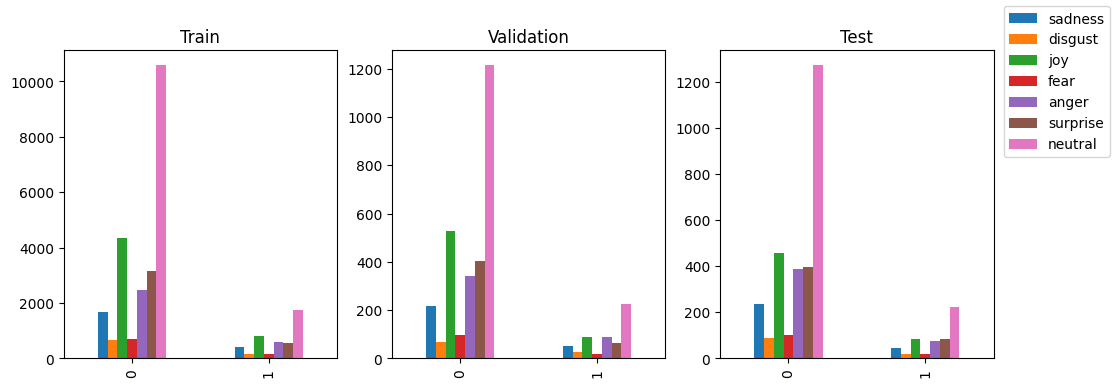

In [6]:
df_manager.plot_emotion_distribution(train_df, val_df, test_df)

In [7]:
model_card = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_card)

model_dir = "./model_dir/"+model_card+"/"
data_collator = DefaultDataCollator()

In [8]:
train_data_tokenized, val_data_tokenized, test_data_tokenized = df_manager.produce_dataset(tokenizer, RANDOM_SEED)

C:\Users\mpsta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [9]:
print(len(train_data_tokenized))
print(len(val_data_tokenized))
print(len(test_data_tokenized))

58
8
27


In [10]:
print(len(train_df['utterances'][555]))
print(train_df['emotions_id'][555])

2
[0, 4]


Models

In [11]:
seeds = [666, 55, 42]

X = train_data_tokenized['dialogue_index']
Y = train_data_tokenized.select_columns(['triggers', 'emotions_id'])
seed_table = {'majority': {}, 'uniform': {},
              'model_BERT': {}, 'model_BERT_Freezed': {}}

id2emotion = df_manager.get_id2emotion()
random_clf = Baseline("uniform", X, Y)
majority_clf = Baseline("most_frequent", X, Y)
for seed in seeds:
    seed_table["uniform"][seed] = random_clf.score()
    seed_table["majority"][seed] = majority_clf.score()

In [12]:
seed_table

{'majority': {666: {'accuracy_emotions': 0.1724,
   'accuracy_triggers': 0.0,
   'f1scores_emotions_instance': 0.0405,
   'f1scores_emotions_flatten': 0.042,
   'f1scores_triggers_instance': 0.0,
   'f1scores_triggers_flatten': 0.0},
  55: {'accuracy_emotions': 0.1724,
   'accuracy_triggers': 0.0,
   'f1scores_emotions_instance': 0.0405,
   'f1scores_emotions_flatten': 0.042,
   'f1scores_triggers_instance': 0.0,
   'f1scores_triggers_flatten': 0.0},
  42: {'accuracy_emotions': 0.1724,
   'accuracy_triggers': 0.0,
   'f1scores_emotions_instance': 0.0405,
   'f1scores_emotions_flatten': 0.042,
   'f1scores_triggers_instance': 0.0,
   'f1scores_triggers_flatten': 0.0}},
 'uniform': {666: {'accuracy_emotions': 0.0862,
   'accuracy_triggers': 0.1724,
   'f1scores_emotions_instance': 0.0329,
   'f1scores_emotions_flatten': 0.0395,
   'f1scores_triggers_instance': 0.2378,
   'f1scores_triggers_flatten': 0.3064},
  55: {'accuracy_emotions': 0.1379,
   'accuracy_triggers': 0.0517,
   'f1scores

In [13]:
def init_pos_weight(data, labels, class_weights=True, factor=1):
    if class_weights:
        pos_weight = list()
        emotions_counts = {label:0 for label in df_manager.unique_emotions}
        for sentence_emotions in data[df_manager.column_emotions_id]:
            for emotion in sentence_emotions:
                emotions_counts[emotion] = emotions_counts[emotion] + 1
        sum_of_all_emotions = sum(emotions_counts.values())
        for label in labels:
            w = (sum_of_all_emotions-emotions_counts[label])/emotions_counts[label]   # num_neg/num_pos for each class as specified in the documentation for BCEWithLogitsLoss
            if w > 1:                       # increase recall of minority classes
                w*=factor                   # factor to magnify the weight (not standard)
                pos_weight.append(w)
            else:
                pos_weight.append(1)        # non minority classes are not influenced (pos_weight = 1)
        return torch.tensor(pos_weight).to("cuda")
    else:
        return torch.ones([len(labels)]).to("cuda")

In [14]:
model_B = BERT_Model_Phrase_Concatenation(df_manager)
def try_model_Concatenation(batch_start, batch_end):
        outputs_text = model_B(utterance_ids=train_data_tokenized[batch_start:batch_end]['utterance_ids'],
                utterance_mask=train_data_tokenized[batch_start:batch_end]['utterance_mask'],
                dialogue_ids=train_data_tokenized[batch_start:batch_end]['dialogue_ids'],
                dialogue_mask=train_data_tokenized[batch_start:batch_end]['dialogue_mask'],
                token_type_ids=None)
        return outputs_text
#outputs_text = try_model_Concatenation(0, 30)
#print(outputs_text['emotion_logits'].shape)
#print(outputs_text['trigger_logits'].shape)

In [15]:
class MultiLabelTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        self.pos_weight = pos_weight
        super().__init__(**kwargs)

    def compute_loss(self, model, inputs, return_outputs=False):
        emotions_true = inputs["emotions_id_one_hot_encoding"].to("cuda")
        triggers_true = inputs["triggers"].float().unsqueeze(1).to("cuda")

        result = model(**inputs)
        
        emotion_logits = result['emotion_logits'].to("cuda")
        trigger_logits = result['trigger_logits'].to("cuda")
        
        loss_fct_emotions = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)        
        loss_fct_triggers = torch.nn.BCEWithLogitsLoss()

        loss_triggers = loss_fct_triggers(trigger_logits, triggers_true)
        loss_emotions = loss_fct_emotions(emotion_logits, emotions_true.float())

        loss = loss_emotions + loss_triggers
        return (loss, {'emotion_logits': emotion_logits, 'trigger_logits': trigger_logits}) if return_outputs else loss

def get_trainer(model, train, val, model_dir, class_weights=True, batch_size=1, epochs=20):
    training_args = TrainingArguments(
        output_dir=model_dir,
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        lr_scheduler_type="cosine_with_restarts",
        save_total_limit = 1,
        load_best_model_at_end=True,
        metric_for_best_model='f1scores_emotions_instance',
        report_to='none',
        label_names=["emotions_id", "triggers", "dialogue_index", "emotions_id_one_hot_encoding"],
    )
    pos_weight = init_pos_weight(concatenate_datasets([train_data_tokenized, val_data_tokenized, test_data_tokenized]), df_manager.emotion2id.keys(), False)
    trainer = MultiLabelTrainer(
        pos_weight=pos_weight,
        model=model,
        args=training_args,
        train_dataset=train,
        eval_dataset=val,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_for_trainer,
    )

    return trainer

In [16]:
seeds = [666]
for seed in seeds:
        set_seeds(seed)
        base_model = BERT_Model_Phrase_Concatenation(df_manager)
        # base_model_freezed = BERT_Model(freeze=True)

        # Create trainer for Conclusion only
        trainer = get_trainer(base_model, train_data_tokenized, val_data_tokenized, model_dir+"baseline", class_weights=True, batch_size=1, epochs=10)

        # Create trainer for Conclusion+Premises
        # trainer_freezed = get_trainer(base_model_freezed, train_dataset, val_dataset, model_dir+"baseline_freezed", class_weights=True, batch_size=1, epochs=10)
        print(f'Training BASE_MODEL with seed {seed}:')
        #trainer.evaluate(val_data_tokenized[0])

        trainer.train()

        #print(f'Training BASE_MODEL_FREEZED with seed {seed}:')
        #trainer_freezed.train()

        #test_prediction_info = trainer.predict(dataset)
        #test_predictions, test_labels = test_prediction_info.predictions, test_prediction_info.label_ids
        #test_metrics.append(compute_metrics([test_predictions, test_labels], list(level_2.keys())))
#
        ## fill seed table
        #seed_table["model_BERT"][seed] = test_bert
        #seed_table["model_BERT_Freezed"][seed] = test_CP

C:\Users\mpsta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Training BASE_MODEL with seed 666:


  0%|          | 0/580 [00:00<?, ?it/s]Could not estimate the number of tokens of the input, floating-point operations will not be computed
                                                
 10%|█         | 58/580 [00:09<01:19,  6.54it/s]

before =  (array([[3.7695054e-04, 1.7802056e-04, 2.1880974e-04, 7.2865419e-05,
        5.5733541e-05, 6.7003522e-05, 9.9903071e-01],
       [3.8497444e-04, 1.9325920e-04, 2.3306040e-04, 7.6501972e-05,
        5.3190499e-05, 6.4498941e-05, 9.9899453e-01],
       [3.7630188e-04, 1.9636186e-04, 2.3159465e-04, 7.7094592e-05,
        5.3656549e-05, 6.6178189e-05, 9.9899882e-01],
       [3.7049418e-04, 1.7544038e-04, 2.1458739e-04, 6.6800632e-05,
        5.6342880e-05, 6.3732972e-05, 9.9905258e-01],
       [3.5577978e-04, 1.7092605e-04, 2.1254957e-04, 6.8909845e-05,
        5.7589292e-05, 6.7701636e-05, 9.9906653e-01],
       [3.8068389e-04, 1.9337636e-04, 2.3070144e-04, 7.2536888e-05,
        5.4367632e-05, 6.6698813e-05, 9.9900168e-01],
       [3.8395065e-04, 1.8289880e-04, 2.1672036e-04, 6.9376474e-05,
        5.5714689e-05, 6.6988076e-05, 9.9902427e-01],
       [3.7049418e-04, 1.7544038e-04, 2.1458739e-04, 6.6800632e-05,
        5.6342880e-05, 6.3732972e-05, 9.9905258e-01]], dtype=float3

                                                 
 20%|██        | 116/580 [00:20<01:13,  6.34it/s]

before =  (array([[7.93257786e-04, 3.33290722e-04, 4.35494003e-04, 1.42975303e-04,
        1.05185885e-04, 1.18324242e-04, 9.98071611e-01],
       [8.23378330e-04, 3.66405817e-04, 4.71347914e-04, 1.52161010e-04,
        1.02288657e-04, 1.15705348e-04, 9.97968733e-01],
       [8.05683376e-04, 3.72105889e-04, 4.68219980e-04, 1.53295754e-04,
        1.03093742e-04, 1.18551572e-04, 9.97978985e-01],
       [7.82770687e-04, 3.29898496e-04, 4.29319072e-04, 1.32036497e-04,
        1.07006905e-04, 1.13063536e-04, 9.98105884e-01],
       [7.43821147e-04, 3.18058446e-04, 4.20117896e-04, 1.34391143e-04,
        1.07989290e-04, 1.18583011e-04, 9.98156965e-01],
       [8.10103898e-04, 3.64824606e-04, 4.63941018e-04, 1.44015023e-04,
        1.04007981e-04, 1.18968463e-04, 9.97994065e-01],
       [8.11185280e-04, 3.43442895e-04, 4.33502515e-04, 1.37064606e-04,
        1.05889150e-04, 1.18798045e-04, 9.98050094e-01],
       [7.82770687e-04, 3.29898496e-04, 4.29319072e-04, 1.32036497e-04,
        1.0700

                                                 
 30%|███       | 174/580 [00:31<00:59,  6.86it/s]

before =  (array([[2.4564376e-03, 6.2781433e-04, 9.9124154e-04, 2.9321379e-04,
        2.0141047e-04, 2.2428008e-04, 9.9520564e-01],
       [2.6180227e-03, 7.0204912e-04, 1.0945374e-03, 3.1793246e-04,
        1.9967367e-04, 2.2308285e-04, 9.9484468e-01],
       [2.5633636e-03, 7.1358273e-04, 1.0878368e-03, 3.2034985e-04,
        2.0124484e-04, 2.2851008e-04, 9.9488515e-01],
       [2.4246818e-03, 6.2154396e-04, 9.7867067e-04, 2.7072316e-04,
        2.0528525e-04, 2.1456870e-04, 9.9528450e-01],
       [2.2717530e-03, 5.9398136e-04, 9.4696379e-04, 2.7279882e-04,
        2.0509932e-04, 2.2270286e-04, 9.9548656e-01],
       [2.5443225e-03, 6.9303613e-04, 1.0676445e-03, 2.9839904e-04,
        2.0130184e-04, 2.2776795e-04, 9.9496764e-01],
       [2.5144408e-03, 6.4715935e-04, 9.8853291e-04, 2.8135837e-04,
        2.0340357e-04, 2.2566099e-04, 9.9513948e-01],
       [2.4246818e-03, 6.2154396e-04, 9.7867067e-04, 2.7072316e-04,
        2.0528525e-04, 2.1456870e-04, 9.9528450e-01]], dtype=float3

                                                 
 40%|████      | 232/580 [00:42<00:49,  6.98it/s]

before =  (array([[8.3756112e-03, 1.1665733e-03, 3.3609408e-03, 7.1868778e-04,
        4.4685983e-04, 4.7541814e-04, 9.8545581e-01],
       [9.3310336e-03, 1.3363131e-03, 3.8354078e-03, 8.0420129e-04,
        4.5689964e-04, 4.8607844e-04, 9.8375016e-01],
       [9.2931790e-03, 1.3723104e-03, 3.8516878e-03, 8.1884320e-04,
        4.6421253e-04, 5.0117431e-04, 9.8369861e-01],
       [7.6730121e-03, 1.1030613e-03, 3.1767511e-03, 6.3184078e-04,
        4.3749198e-04, 4.3952529e-04, 9.8653841e-01],
       [7.4611851e-03, 1.0799250e-03, 3.1225639e-03, 6.5077457e-04,
        4.4456596e-04, 4.6199560e-04, 9.8677897e-01],
       [8.4323399e-03, 1.2619797e-03, 3.5716183e-03, 7.1892038e-04,
        4.4173267e-04, 4.7776877e-04, 9.8509568e-01],
       [7.9737529e-03, 1.1488589e-03, 3.2134852e-03, 6.5739598e-04,
        4.3463113e-04, 4.6237351e-04, 9.8610955e-01],
       [7.6730121e-03, 1.1030613e-03, 3.1767511e-03, 6.3184078e-04,
        4.3749198e-04, 4.3952529e-04, 9.8653841e-01]], dtype=float3

                                                 
 50%|█████     | 290/580 [00:53<00:42,  6.82it/s]

before =  (array([[6.9831323e-04, 4.6961827e-04, 1.5313808e-03, 2.6232938e-04,
        1.9941271e-04, 2.1500156e-04, 9.9662399e-01],
       [7.3736743e-04, 5.1775592e-04, 1.6914080e-03, 2.8286822e-04,
        1.9728187e-04, 2.1357043e-04, 9.9635977e-01],
       [7.4480620e-04, 5.3619139e-04, 1.7140363e-03, 2.9086325e-04,
        2.0168653e-04, 2.2118867e-04, 9.9629128e-01],
       [6.1278575e-04, 4.3284206e-04, 1.4038689e-03, 2.2585464e-04,
        1.9079527e-04, 1.9647591e-04, 9.9693727e-01],
       [6.3442369e-04, 4.3987657e-04, 1.4315281e-03, 2.4096455e-04,
        2.0008066e-04, 2.1192204e-04, 9.9684107e-01],
       [6.6407997e-04, 4.9061002e-04, 1.5694229e-03, 2.5351375e-04,
        1.9177327e-04, 2.1076096e-04, 9.9661982e-01],
       [6.3243910e-04, 4.4860144e-04, 1.4153157e-03, 2.3318391e-04,
        1.8865701e-04, 2.0532163e-04, 9.9687648e-01],
       [6.1278575e-04, 4.3284206e-04, 1.4038689e-03, 2.2585464e-04,
        1.9079527e-04, 1.9647591e-04, 9.9693727e-01]], dtype=float3

                                                 
 60%|██████    | 348/580 [01:04<00:30,  7.52it/s]

before =  (array([[1.1732969e-03, 6.7773031e-04, 2.9569669e-03, 4.2095163e-04,
        2.9755494e-04, 3.1230156e-04, 9.9416107e-01],
       [1.2565741e-03, 7.5686642e-04, 3.3200439e-03, 4.6045170e-04,
        2.9814627e-04, 3.1383493e-04, 9.9359411e-01],
       [1.2713803e-03, 7.8544806e-04, 3.3719451e-03, 4.7449555e-04,
        3.0532278e-04, 3.2557469e-04, 9.9346584e-01],
       [1.0203728e-03, 6.1897654e-04, 2.6822768e-03, 3.5835916e-04,
        2.8244889e-04, 2.8302241e-04, 9.9475467e-01],
       [1.0570551e-03, 6.2974554e-04, 2.7364660e-03, 3.8297620e-04,
        2.9651198e-04, 3.0548757e-04, 9.9459177e-01],
       [1.1174892e-03, 7.0836669e-04, 3.0353456e-03, 4.0712015e-04,
        2.8649290e-04, 3.0641610e-04, 9.9413884e-01],
       [1.0536120e-03, 6.4155489e-04, 2.7041347e-03, 3.7022468e-04,
        2.7937433e-04, 2.9588991e-04, 9.9465525e-01],
       [1.0203728e-03, 6.1897654e-04, 2.6822768e-03, 3.5835916e-04,
        2.8244889e-04, 2.8302241e-04, 9.9475467e-01]], dtype=float3

                                                 
 70%|███████   | 406/580 [01:15<00:22,  7.62it/s]

before =  (array([[3.5549821e-03, 1.7998471e-03, 1.5946757e-02, 1.3133348e-03,
        7.3129259e-04, 7.4656669e-04, 9.7590715e-01],
       [3.9035499e-03, 2.0612318e-03, 1.8472444e-02, 1.4777117e-03,
        7.5089099e-04, 7.6802913e-04, 9.7256607e-01],
       [3.9657741e-03, 2.1507454e-03, 1.8873392e-02, 1.5312374e-03,
        7.7239762e-04, 8.0022105e-04, 9.7190619e-01],
       [3.0346338e-03, 1.6122191e-03, 1.4136194e-02, 1.0897554e-03,
        6.8228884e-04, 6.6400680e-04, 9.7878087e-01],
       [3.1495655e-03, 1.6417940e-03, 1.4419762e-02, 1.1683288e-03,
        7.1775814e-04, 7.1783277e-04, 9.7818494e-01],
       [3.3929416e-03, 1.8829524e-03, 1.6418759e-02, 1.2716022e-03,
        7.0574228e-04, 7.3408231e-04, 9.7559398e-01],
       [3.1352290e-03, 1.6698004e-03, 1.4242576e-02, 1.1269175e-03,
        6.7512470e-04, 6.9427863e-04, 9.7845614e-01],
       [3.0346338e-03, 1.6122191e-03, 1.4136194e-02, 1.0897554e-03,
        6.8228884e-04, 6.6400680e-04, 9.7878087e-01]], dtype=float3

                                                 
 80%|████████  | 464/580 [01:26<00:18,  6.36it/s]

before =  (array([[0.00883909, 0.00298373, 0.05143853, 0.00271831, 0.00138921,
        0.00130319, 0.931328  ],
       [0.01009038, 0.00354871, 0.06272578, 0.00319028, 0.00147125,
        0.00137788, 0.9175956 ],
       [0.01039737, 0.00376878, 0.06559534, 0.003374  , 0.00153546,
        0.00145554, 0.91387355],
       [0.00698021, 0.00246278, 0.04052754, 0.00203113, 0.00120915,
        0.00108622, 0.9457029 ],
       [0.00755114, 0.00263049, 0.04426742, 0.00231491, 0.00132774,
        0.00122012, 0.94068813],
       [0.00820239, 0.00303008, 0.05069588, 0.00252784, 0.00130492,
        0.00125044, 0.9329884 ],
       [0.00723816, 0.00256229, 0.04101449, 0.00211146, 0.00119848,
        0.00114056, 0.9447346 ],
       [0.00698021, 0.00246278, 0.04052754, 0.00203113, 0.00120915,
        0.00108622, 0.9457029 ]], dtype=float32), array([[3.8718917e-05],
       [3.9988190e-05],
       [3.9225924e-05],
       [3.9592800e-05],
       [3.8929735e-05],
       [3.9360901e-05],
       [3.9191451e-0

 86%|████████▋ | 501/580 [01:33<00:12,  6.53it/s]

{'loss': 1.4337, 'grad_norm': 0.12284259498119354, 'learning_rate': 9.242458032904311e-07, 'epoch': 8.62}


                                                 
 90%|█████████ | 522/580 [01:37<00:08,  6.96it/s]

before =  (array([[0.01555728, 0.00445369, 0.11394073, 0.00476799, 0.0021094 ,
        0.00195981, 0.8572111 ],
       [0.01801058, 0.00538175, 0.14202292, 0.00569557, 0.0022504 ,
        0.00208693, 0.8245519 ],
       [0.01873614, 0.00579065, 0.15099107, 0.00612044, 0.00237295,
        0.00222718, 0.8137615 ],
       [0.01153914, 0.00344609, 0.08148988, 0.00325903, 0.00174067,
        0.00154993, 0.8969753 ],
       [0.01293839, 0.00382651, 0.09424792, 0.00391506, 0.00198187,
        0.0018006 , 0.8812897 ],
       [0.01406613, 0.00441281, 0.10809252, 0.0042744 , 0.00193383,
        0.00184022, 0.8653802 ],
       [0.01200898, 0.00359991, 0.08273146, 0.00340389, 0.0017272 ,
        0.00163404, 0.89489454],
       [0.01153914, 0.00344609, 0.08148988, 0.00325903, 0.00174067,
        0.00154993, 0.8969753 ]], dtype=float32), array([[3.7496229e-05],
       [3.9459592e-05],
       [3.8853075e-05],
       [3.7897058e-05],
       [3.7324698e-05],
       [3.8102491e-05],
       [3.7497946e-0

                                                 
100%|██████████| 580/580 [01:48<00:00,  5.72it/s]

before =  (array([[0.01991186, 0.0056069 , 0.17632198, 0.00632236, 0.0025765 ,
        0.00238546, 0.78687495],
       [0.02290825, 0.00675311, 0.21920092, 0.00752638, 0.00272708,
        0.00252055, 0.7383637 ],
       [0.02378858, 0.00726882, 0.23313151, 0.00809557, 0.00287367,
        0.00268915, 0.7221527 ],
       [0.01463394, 0.00428888, 0.123597  , 0.00423451, 0.00211348,
        0.00187168, 0.8492605 ],
       [0.01652044, 0.00479958, 0.14486343, 0.00515549, 0.00242382,
        0.00219102, 0.82404625],
       [0.01791663, 0.00553135, 0.16600901, 0.00562242, 0.00235241,
        0.00223157, 0.80033666],
       [0.01525566, 0.00448731, 0.12565131, 0.00443334, 0.002098  ,
        0.00197651, 0.8460978 ],
       [0.01463394, 0.00428888, 0.123597  , 0.00423451, 0.00211348,
        0.00187168, 0.8492605 ]], dtype=float32), array([[3.7567417e-05],
       [4.0085248e-05],
       [3.9623246e-05],
       [3.7457026e-05],
       [3.7067392e-05],
       [3.8103652e-05],
       [3.7062793e-0

100%|██████████| 580/580 [01:51<00:00,  5.21it/s]

{'train_runtime': 111.3056, 'train_samples_per_second': 5.211, 'train_steps_per_second': 5.211, 'train_loss': 1.433266751519565, 'epoch': 10.0}
